In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets,transforms
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [22]:
folders=['/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign','/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant']
size=256

In [23]:
def load_image(path, size, grayscale=True):
    mode='L' if grayscale is True else 'RGB'
    img = Image.open(path).convert(mode)
    img = img.resize((size,size))
    image = transforms.ToTensor()(img)
    return image

In [24]:
def load_data(folders, size=256):
  images = []
  masks = []
  prev_image, current_mask = None, None

  for folder in folders:
    folder = sorted(glob(folder  + '/*'))

    for fp in folder:
        img = load_image(fp, size=256, grayscale=True)

        if 'mask' in fp.lower():
            current_mask = img if current_mask is None else (current_mask + img > 0.5).float() 
        else:
            if prev_image is not None:
                images.append(prev_image)
                masks.append(current_mask)
            prev_image, current_mask = img, None
    if prev_image is not None:
        images.append(prev_image)
        masks.append(current_mask)

  return torch.stack(images), torch.stack(masks)
        

In [25]:
class BUIdataset(Dataset):
    def __init__(self,images,masks):
        super().__init__()
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        return self.images[idx], self.masks[idx]
    

In [26]:
images, masks = load_data(folders, size =256)
dataset = BUIdataset(images, masks)

train_set = int(0.8 * len(dataset))
test_set = len(dataset) - train_set

train_dataset, test_dataset = random_split(dataset, [train_set,test_set], generator=torch.Generator().manual_seed(42))


In [39]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [27]:
len(dataset)

648

In [64]:
class convblock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
                                  nn.BatchNorm2d(out_channels),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
                                  nn.BatchNorm2d(out_channels),
                                  nn.ReLU(inplace=True))         
    def forward(self,x):
        return self.conv(x)                                    

In [65]:
class Encoder(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.d_conv = convblock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self,x):
        x_conv = self.d_conv(x)
        x_pool = self.maxpool(x_conv)
        return x_conv,x_pool
        
        

In [66]:
class Decoder(nn.Module):
     def __init__(self,in_channels,out_channels):
         super().__init__()
         self.up_conv = nn.ConvTranspose2d(in_channels,out_channels,kernel_size=2,stride=2, padding=0)
         self.conv = nn.Sequential(
            # Input channels must be out_channels * 2 (from upsampling + skip connection)
            nn.Conv2d(out_channels*2, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

     def forward(self, x, skip_con): # Note the input arguments
         # 1. Upsample the main feature map
         x = self.up_conv(x) 
         
         # 2. Concatenate with the skip connection
         x = torch.cat([x, skip_con], dim=1) # FIX APPLIED HERE: Use 'x'
         
         # 3. Apply the double convolution
         x = self.conv(x)

         return x

In [70]:
class Unet(nn.Module):
   def __init__(self,in_channels,out_channels):
        super().__init__()

        # Encoder
        self.enc1 = Encoder(in_channels,64)
        self.enc2 = Encoder(64,128)
        self.enc3 = Encoder(128,256)
        self.enc4 = Encoder(256,512)

        # Bottleneck
        self.bottleneck = convblock(512,1024)

        # Decoder
        self.dec4 = Decoder(1024,512)
        self.dec3 = Decoder(512,256)
        self.dec2 = Decoder(256,128)
        self.dec1 = Decoder(128,64)

        # output
        self.out_conv = nn.Conv2d(64,out_channels,kernel_size=1)
        
   def forward(self,x):
         s1,p1 = self.enc1(x)
         s2,p2 = self.enc2(p1)
         s3,p3 = self.enc3(p2)
         s4,p4 = self.enc4(p3)

         b = self.bottleneck(p4)

         d4 = self.dec4(b,s4)
         d3 = self.dec3(d4,s3)
         d2 = self.dec2(d3,s2)
         d1 = self.dec1(d2,s1)

         return self.out_conv(d1)
         

In [71]:
model = Unet(in_channels=1,out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [72]:
import torch.optim as optim
from tqdm import tqdm

# --- Setup ---
# Assuming 'model' (your U-Net), 'CombinedLoss', and 'DEVICE' are defined
model.to(device)

NUM_EPOCHS = 25

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train() # Set the model to training mode
    running_loss = 0.0
    
    for images, masks in tqdm(dataloader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

# --- Main Training Run ---
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    print(f"Train Loss: {train_loss:.4f}")
    
# Save the final model after all epochs are complete
torch.save(model.state_dict(), 'final_unet_model.pth')
print("Training complete. Final model saved.")


Epoch 1/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.4405

Epoch 2/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.3273

Epoch 3/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.2927

Epoch 4/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.2673

Epoch 5/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.2459

Epoch 6/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Train Loss: 0.2294

Epoch 7/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.2084

Epoch 8/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.1974

Epoch 9/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.1874

Epoch 10/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.1740

Epoch 11/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.1615

Epoch 12/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.1576

Epoch 13/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.1520

Epoch 14/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.1398

Epoch 15/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.1369

Epoch 16/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.60it/s]


Train Loss: 0.1303

Epoch 17/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.1215

Epoch 18/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.1246

Epoch 19/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.1074

Epoch 20/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.1074

Epoch 21/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.1023

Epoch 22/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.0915

Epoch 23/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.0931

Epoch 24/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.0872

Epoch 25/25


Training: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Train Loss: 0.0810
Training complete. Final model saved.


In [77]:
import torch

# ----- Pixel Accuracy -----
def pixel_accuracy(outputs, masks):
    outputs = torch.sigmoid(outputs)         # logits → probabilities
    preds = (outputs > 0.5).float()          # threshold at 0.5
    correct = (preds == masks).float()
    return correct.mean().item()


# ----- Dice Score -----
def dice_score(outputs, masks, eps=1e-7):
    outputs = torch.sigmoid(outputs)
    preds = (outputs > 0.5).float()

    intersection = (preds * masks).sum()
    union = preds.sum() + masks.sum()
    dice = (2 * intersection + eps) / (union + eps)
    return dice.item()


# ----- IoU (Jaccard Index) -----
def iou_score(outputs, masks, eps=1e-7):
    outputs = torch.sigmoid(outputs)
    preds = (outputs > 0.5).float()

    intersection = (preds * masks).sum()
    union = preds.sum() + masks.sum() - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.item()


In [78]:
def evaluate_on_test(model, test_loader, device):
    model.eval()

    total_acc = 0
    total_dice = 0
    total_iou = 0
    count = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)

            total_acc += pixel_accuracy(outputs, masks)
            total_dice += dice_score(outputs, masks)
            total_iou += iou_score(outputs, masks)

            count += 1

    return total_acc / count, total_dice / count, total_iou / count


In [75]:
def evaluate(model, dataloader, device):
    model.eval()
    total_acc = 0
    total_dice = 0
    total_iou = 0
    count = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)

            total_acc += pixel_accuracy(outputs, masks)
            total_dice += dice_score(outputs, masks)
            total_iou += iou_score(outputs, masks)

            count += 1

    return total_acc / count, total_dice / count, total_iou / count


In [79]:
acc, dice, iou = evaluate(model, test_loader, device)

print(f"Accuracy: {acc:.4f}")
print(f"Dice:     {dice:.4f}")
print(f"IoU:      {iou:.4f}")


Accuracy: 0.9395
Dice:     0.7328
IoU:      0.5878


In [82]:
import torch
import matplotlib.pyplot as plt

def plot_output(model, test_loader, device):
    model.eval()

    # get one batch from test loader
    images, masks = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        outputs = torch.sigmoid(outputs)      # convert to probabilities
        preds = (outputs > 0.5).float()       # threshold at 0.5

    # take first sample
    img = images[0].cpu().squeeze().numpy()
    mask = masks[0].cpu().squeeze().numpy()
    pred = preds[0].cpu().squeeze().numpy()

    # plot
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(img, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred, cmap="gray")
    plt.axis("off")

    plt.show()


In [83]:
import torch
import matplotlib.pyplot as plt

def plot_multiple_outputs(model, test_loader, device, num_samples=5):
    model.eval()
    
    # get one batch
    images, masks = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        preds = (outputs > 0.5).float()

    plt.figure(figsize=(12, num_samples * 3))

    for i in range(num_samples):
        img = images[i].cpu().squeeze().numpy()
        mask = masks[i].cpu().squeeze().numpy()
        pred = preds[i].cpu().squeeze().numpy()

        # Image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img, cmap="gray")
        if i == 0: plt.title("Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(mask, cmap="gray")
        if i == 0: plt.title("Ground Truth")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred, cmap="gray")
        if i == 0: plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


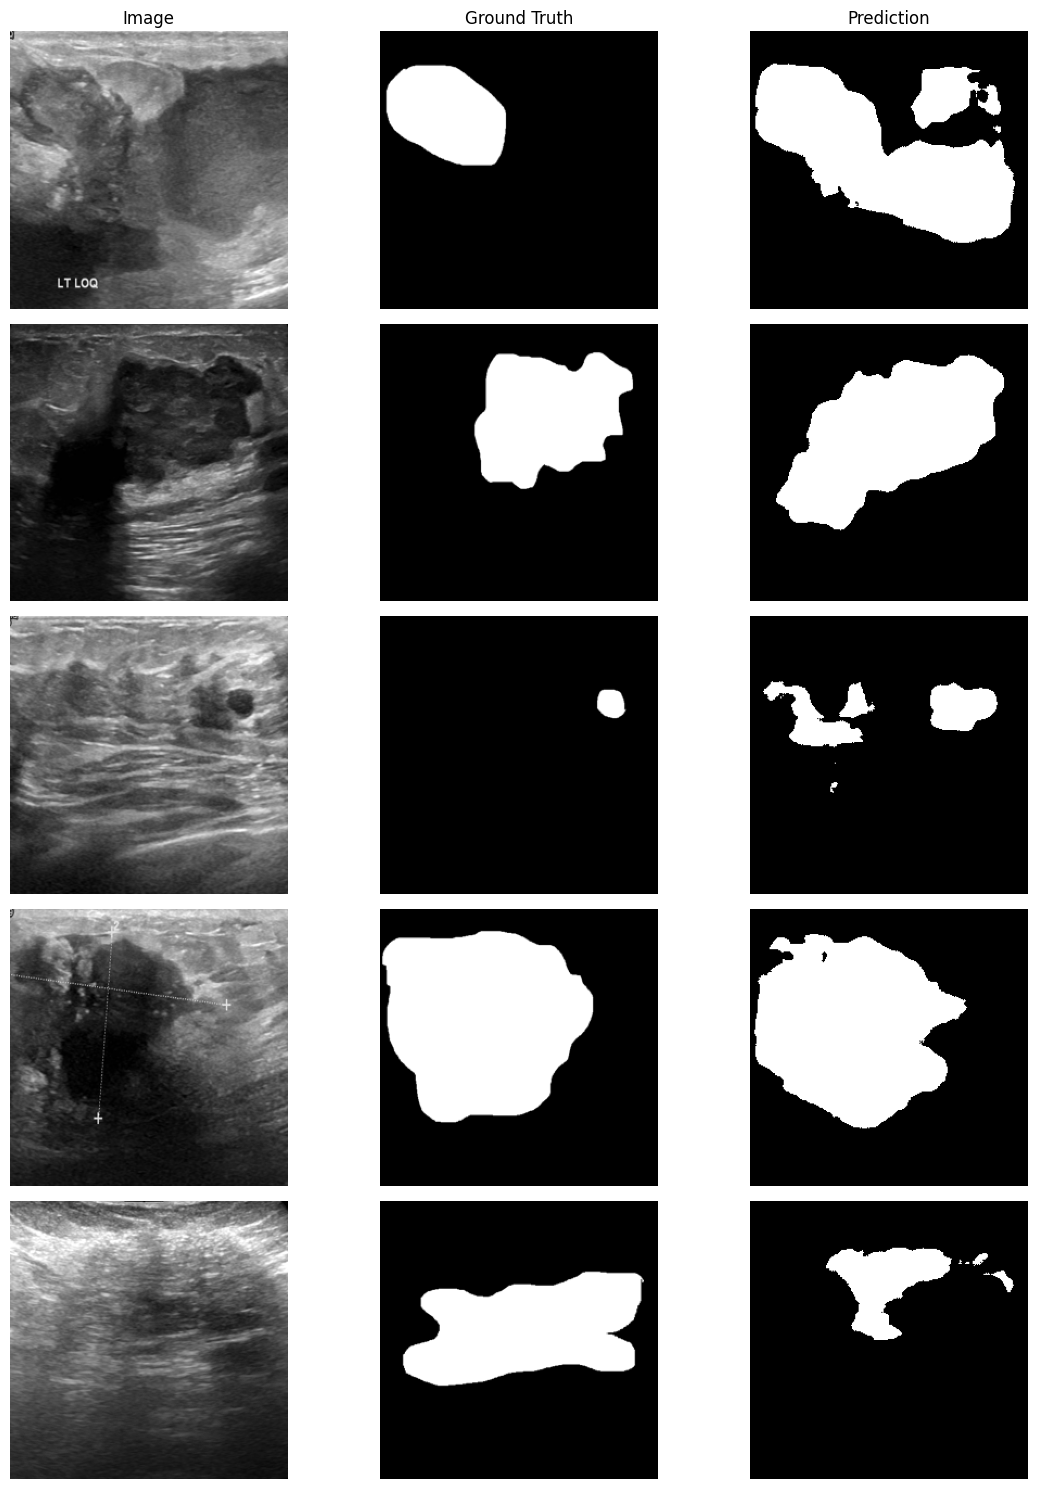

In [84]:
plot_multiple_outputs(model, test_loader, device, num_samples=5)
